In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib as mpl
from matplotlib import lines

from scipy.io import loadmat
from scipy.interpolate import griddata
from utils import get_boundary_data

from matplotlib.ticker import EngFormatter, ScalarFormatter, FormatStrFormatter
np.random.seed(1234)
tf.random.set_seed(1234)

2024-01-09 10:00:08.962735: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 10:00:09.015968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 10:00:09.816835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## For Same grid locations

## Interpolation to get the same grid locations for u and v

In [2]:
def interpolated_values(grid_size, bound_val, data_dir):
    
    x = np.linspace(start=0., stop=1., num=grid_size)
    y = np.linspace(start=0., stop=1., num=grid_size)
    X, Y = np.meshgrid(x, y)
    U = np.zeros((grid_size, grid_size))
    V = np.zeros((grid_size, grid_size))
    P = np.zeros((grid_size-2, grid_size-2))
    grid_data = loadmat('grid_data.mat')
    side_bc = np.zeros((grid_size-2, 1))
    bbc = np.zeros((1, grid_size))
    tbc = np.ones_like(bbc) * bound_val
    tbc[0, 0] = 0
    tbc[0, -1] = 0

    data = loadmat(data_dir)
    u_interpolated_data = griddata(
        np.hstack(
            (grid_data['XU'].reshape((-1, 1), order='F'), grid_data['YU'].reshape((-1, 1), order='F'))),
        data['u'][4:], np.hstack((X[1:-1,1:-1].reshape((-1,1)), Y[1:-1, 1:-1].reshape((-1, 1)))))
    v_interpolated_data = griddata(
        np.hstack((grid_data['XV'].reshape((-1, 1), order='F'), grid_data['YV'].reshape((-1, 1), order='F'))), 
        data['v'][4:], np.hstack((X[1:-1,1:-1].reshape((-1,1)), Y[1:-1, 1:-1].reshape((-1, 1)))))
    p_interpolated_data = griddata(
        np.hstack((grid_data['XP'].reshape((-1, 1), order='F'), grid_data['YP'].reshape((-1, 1), order='F'))), 
        data['P'][4:], np.hstack((X[1:-1,1:-1].reshape((-1,1)), Y[1:-1, 1:-1].reshape((-1, 1)))))
    u_padded = np.concatenate((
        bbc, np.concatenate((side_bc, u_interpolated_data.reshape((grid_size-2, grid_size-2)),side_bc), 
                            axis=1), tbc), axis=0)
    v_padded = np.concatenate((bbc, np.concatenate((side_bc, v_interpolated_data.reshape((grid_size-2, grid_size-2)), 
                                                    side_bc), axis=1), bbc), axis=0)
    return X, Y, u_padded, v_padded

In [3]:
def get_predictions_bp(X, Y, grid_size, bound_val, model, bp=True):
    x_test = X.reshape((-1, 1))
    y_test = Y.reshape((-1, 1))
    
    if bp:
        _, _, _, _, _, _, xtest_bc, ytest_bc, utest_bc, vtest_bc, _, _, _, _ \
                = get_boundary_data(start=0., stop=1., grid_size=grid_size, top_velocity=bound_val)
        test_data = [x_test, y_test, xtest_bc, ytest_bc, utest_bc,
                       vtest_bc]
    else:
        test_data = [x_test, y_test]
        
    u_test, v_test, p_test = model.predict(test_data, batch_size=32)
    
    return u_test.reshape(X.shape), v_test.reshape(X.shape), p_test.reshape(X.shape)

In [4]:
def get_plots_bp(u_true, v_true, u_test, v_test, u_test_AD, v_test_AD, pt, ps, pd, shrink=1):
    
    fig, axs = plt.subplots(len(u_true), 3,sharex=True, sharey=True, figsize=(9,3))
    fig.tight_layout()
    axs = axs.flat
    
    for i in range(len(u_true)):
        strm = axs[i*2+0].streamplot(X, Y-1, u_test[i], v_test[i],
                                     color='k', 
                                     linewidth=1.2)
        vm = (u_true[i]**2 + v_true[i]**2)**0.5
        level = np.linspace(vm.min(), vm.max(), num=20)
        strm1 = axs[i*2+0].contourf(X, Y-1, vm, level, cmap='Blues', extend='both')
        cbar = fig.colorbar(strm1, ax=axs[i*2+0], shrink=shrink)
        cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
        cbar.set_label('|V|(non-dim)', loc='center')
        axs[i*2+0].set_title(pt[i*2+1])
        axs[i*2+0].set_xlim(0, 1)
        axs[i*2+0].set_ylim(-1, 0)
    

        if i == len(u_true)-1:
            axs[i*2+0].set_xlabel('X')
        axs[i*2+0].set_ylabel('Z')
        axs[i*2+0].set_box_aspect(1)
        
        strm = axs[i*2+2].streamplot(X, Y-1, u_true[i], v_true[i],
                                     color='k',
                                     linewidth=1.2)
        vm = (u_true[i]**2 + v_true[i]**2)**0.5
        level = np.linspace(vm.min(), vm.max(), num=20)
        strm1 = axs[i*2+2].contourf(X, Y-1, vm, level, cmap='Blues')
        
        cbar = fig.colorbar(strm1, ax=axs[i*2+2], shrink=shrink)
        cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
        cbar.set_label('|V|(non-dim)', loc='center')
        axs[i*2+2].set_title(pt[i*2+0])
        axs[i*2+2].set_xlim(0, 1)
        axs[i*2+2].set_ylim(-1, 0)
        if i == len(u_true)-1:
            axs[i*2+2].set_xlabel('X')
        axs[i*2+2].set_box_aspect(1)


        strm = axs[i*2+1].streamplot(X, Y-1, u_test_AD[i], v_test_AD[i],
                                     color='k',
                                     linewidth=1.2)
        vm = (u_true[i]**2 + v_true[i]**2)**0.5
        level = np.linspace(vm.min(), vm.max(), num=20)
        strm1 = axs[i*2+1].contourf(X, Y-1, vm, level, cmap='Blues')
        
        cbar = fig.colorbar(strm1, ax=axs[i*2+1], shrink=shrink)
        cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
        cbar.set_label('|V|(non-dim)', loc='center')
        axs[i*2+1].set_title(pt[i*2+2])
        axs[i*2+1].set_xlim(0, 1)
        axs[i*2+1].set_ylim(-1, 0)
        if i == len(u_true)-1:
            axs[i*2+1].set_xlabel('X')
        axs[i*2+1].set_box_aspect(1)
        
    if ps:
        plt.savefig('Results/'+pd + '.png', dpi=300, bbox_inches = 'tight')
    

## Load Trained Model

## Learning Curves for layers(FVD,AD)

In [ ]:

df_FVD = pd.read_csv("Results/Re_1000_FVD_loss.csv")
df_AD = pd.read_csv("Results/Re_1000_AD_loss.csv")


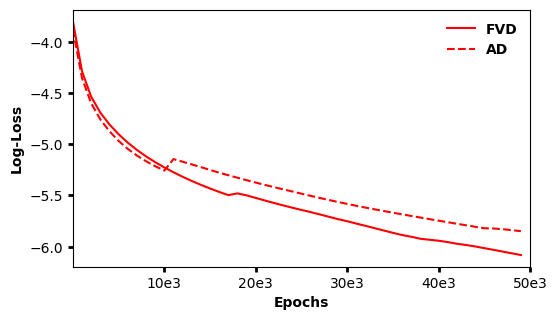

In [6]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes((0.1, 0.1, 8/14, 6/14))
ax.tick_params(axis='x',which='major',direction='out',width=2,labelsize=10)
ax.set_xticks([10, 20, 30, 40, 50])
ax.set_xticklabels(['10e3', '20e3', '30e3', '40e3', '50e3'])
ax.tick_params(axis='y',which='major',direction='out',width=2,labelsize=10)
epochs = np.arange(0, 50)


plt.plot(epochs, df_FVD['loss'], label='FVD', color='red')
plt.plot(epochs, df_AD['loss'], label='AD', color='red', linestyle = '--')

plt.legend(fancybox=False, title_fontsize=10,frameon=False, prop={'weight': 'bold'})
plt.xlim([0, 50])
plt.xlabel('Epochs', fontsize=10, fontweight='bold')
plt.ylabel('Log-Loss', fontsize=10, fontweight='bold')
plt.savefig('Results/'+'learning_curves.png', dpi=300, bbox_inches = 'tight')

### Higher Reynolds Number (Re=1000) using Learning Rate Schedular(FVD, Figure 9a)

In [ ]:
nn_model = tf.keras.models.load_model('saved_model/ICCS_my_model_Re_1000_layers_5_lrs')
nn_model_AD = tf.keras.models.load_model('saved_model/ICCS_my_model_Re_1000_layers_5_AD_lrs')
grid_size=64
bound_values = [1]
data_dir = {"1": 'Re_1000.mat'}
bp = False

u_true = []
u_pred = []
u_pred_AD = []
v_true = []
v_pred = []
v_pred_AD = []
for i in range(len(bound_values)):
    X, Y, u_padded, v_padded = interpolated_values(grid_size=grid_size, 
                                                   bound_val=bound_values[i], 
                                                   data_dir=data_dir[str(i+1)])
    u_test, v_test, p_test = get_predictions_bp(X=X, Y=Y, grid_size=grid_size,
                                                bound_val=bound_values[i], model=nn_model,bp=bp)

    u_test_AD, v_test_AD, p_test_AD = get_predictions_bp(X=X, Y=Y, grid_size=grid_size,
                                                bound_val=bound_values[i], model=nn_model_AD,bp=bp)
    u_true.append(u_padded)
    v_true.append(v_padded)
    u_pred.append(u_test)
    v_pred.append(v_test)
    u_pred_AD.append(u_test_AD)
    v_pred_AD.append(v_test_AD)

2024-01-09 10:00:12.597113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46850 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-01-09 10:00:12.597866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46862 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:5e:00.0, compute capability: 8.6
2024-01-09 10:00:12.598402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46862 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


 46/128 [=========>....................] - ETA: 0s

2024-01-09 10:00:15.495201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


128/128 [==============================] - 0s 3ms/step


<Figure size 640x480 with 0 Axes>

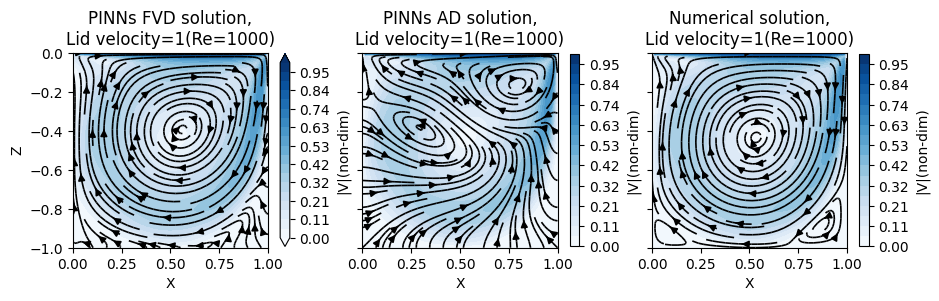

In [8]:
pd = 'top_velocity_1_Re_1000_IJCAI'
pt = ['Numerical solution,\nLid velocity=1(Re=1000)', 'PINNs FVD solution,\nLid velocity=1(Re=1000)','PINNs AD solution,\nLid velocity=1(Re=1000)' ]
plt.cla()
plt.clf()
get_plots_bp(u_true=u_true, v_true=v_true, u_test = u_pred, v_test=v_pred, u_test_AD= u_pred_AD, v_test_AD= v_pred_AD,
             ps=True, pt=pt, pd=pd, shrink=0.8)